In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
pd.options.display.float_format = "{:.4f}".format
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
plt.rcParams["figure.figsize"] = (16,10)
plt.style.use("~/.dracula.mplstyle")
import quandl
import functools, re
import statsmodels.api as sm
from collections import Counter

# QUANDL Config
import os, sys
parent_path = os.path.abspath(os.path.join('..'))
if parent_path not in sys.path:
    sys.path.append(parent_path)
from common.config import QUANDL_API_KEY  # If you are not Philip, you don't have config
                                          # unless you make your own.

quandl.ApiConfig.api_key = QUANDL_API_KEY # Replace with your API key if running.

In [2]:
START_DATE    = "2009-01-01"
END_DATE      = "2021-12-31"

FX_DB     = "CUR/"
CURRENCIES = ["GBP", "ZAR", "THB", "PKR", "PHP"]
YC_DB = "YC/"
COUNTRIES = ["GBR_ISSC", "GBR", "ZAF", "THA", "PAK", "PHL"]

In [3]:
par_raw = quandl.get([YC_DB + c for c in COUNTRIES], start_date=START_DATE, end_date=END_DATE)
fx_raw = quandl.get([FX_DB + c for c in CURRENCIES], start_date=START_DATE, end_date=END_DATE)

## Clean Data

Map Yield Curve par data into a friendly MultiIndex for future slicing and usage.

In [4]:
def clean_columns(s: str, pre=len(YC_DB)):
    """Takes in Quandl formatted column names...
    returns a list to construct a pd.MultiIndex
    "YC/GBR_ISSC - 0.08Y" -> ['GBR', 0.08]
    """
    mapper = {'0.08Y': 0.08, '3-Month': 0.25, '6-Month': 0.5,
              '9-Month': 0.75, '12-Month': 1, '3to5-Year': 4, '5to10-Year': 7.5, 
              '10-Year': 10, '1-Month': 0.08, '1-Year': 1, '2-Year': 2, '3-Year': 3,
              '4-Year': 4, '5-Year': 5, '6-Year': 6, '7-Year': 7, '8-Year': 8, '9-Year': 9,
              '15-Year': 15, '20-Year': 20, '25-Year':25}
    
    ret = re.split(r"([A-Z]\d{4})|( - )", s[pre:])
    coun = ret[0].split('_')[0]
    ten = mapper[ret[-1]]
    return [coun, ten]

test_col = par_raw.columns[0]
print(f"IN:\n{test_col}\nOUT:\n{clean_columns(test_col)}")

par_raw = pd.concat([par_raw.iloc[:, 0], par_raw.iloc[:, 60:]], axis=1)

par_cols = pd.MultiIndex.from_arrays(
    [[clean_columns(c)[0] for c in par_raw.columns], [clean_columns(c)[1] for c in par_raw.columns]],
    names=("COUNTRY", "TENOR"))

par_raw.columns = par_cols
par_raw = par_raw / 100

fx_raw.columns = [c[4:].split(" - ")[0] for c in fx_raw.columns]

IN:
YC/GBR_ISSC - 0.08Y
OUT:
['GBR', 0.08]


## South Africa is missing 5 Year

Fill it in using interp

In [5]:
fives = []

for d, row in par_raw["ZAF"].iterrows():
    five = np.interp(5, row.index.values, row.values)
    fives.append(five)
    
par_raw[("ZAF", 5.0)] = fives

## Turn `Spot Rates` to `Zero Rates`

To discount coupons from off-the-run bonds.

In [6]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve].dropna()
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.25, 0, step=-0.25)[::-1]
                coupon = 0.25*spot_rate
                z = np.interp(times, zcb_rates[curve].dropna().index.values, zcb_rates[curve].dropna().values) # Linear interpolation
                preceding_coupons_val = (coupon*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon))/tenor
    return zcb_rates

cou = par_raw.resample("W-Wed").last()
cou = cou.ffill().where(cou.bfill().notna()) #.interpolate(method="ffill", limit_area="inside")
zeros = []

for d, row in cou.iterrows():
    df = row.reset_index().pivot(index="TENOR", columns="COUNTRY").droplevel(None, axis=1)
    zero = compute_zcb_curve(df)
    zero = zero.stack().swaplevel(0,1,0)
    zeros.append(zero)

zeros = pd.concat(zeros, axis=1).T#.interpolate(method="ffill", limit_area="inside")
zeros = zeros.ffill().where(zeros.bfill().notna())
zeros.index = cou.index

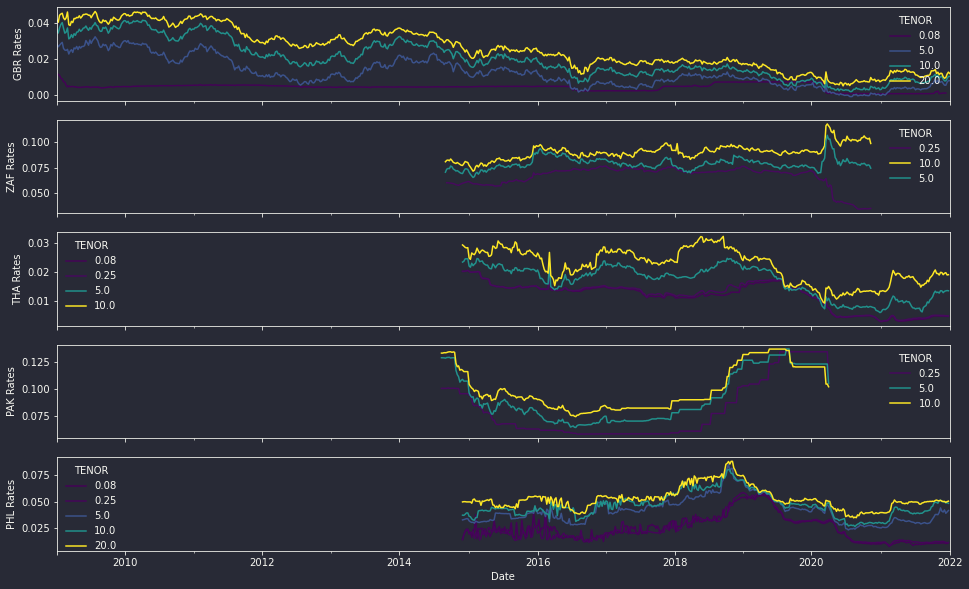

In [7]:
curr = cou.columns.get_level_values(0).unique()
fig, axs = plt.subplots(len(curr), sharex=True)

for i, c in enumerate(curr):
    to_plot = cou[c]
    to_plot = to_plot[[c for c in to_plot.columns if c in [0.08, 0.25, 5, 10, 20]]]
    to_plot.plot(ax=axs[i], color=cm.viridis(to_plot.columns / max(to_plot.columns)))
    axs[i].set_ylabel(f"{c} Rates")
    
plt.show()

## Align FX DataFrame

And rename it to follow Yield Curve naming conventions.

In [8]:
fx_raw.columns = pd.MultiIndex.from_arrays([np.array(COUNTRIES[1:]), np.zeros(len(COUNTRIES[1:]))], 
                                           names=("COUNTRY", "TENOR"))

fx = fx_raw.resample("W-Fri").last()

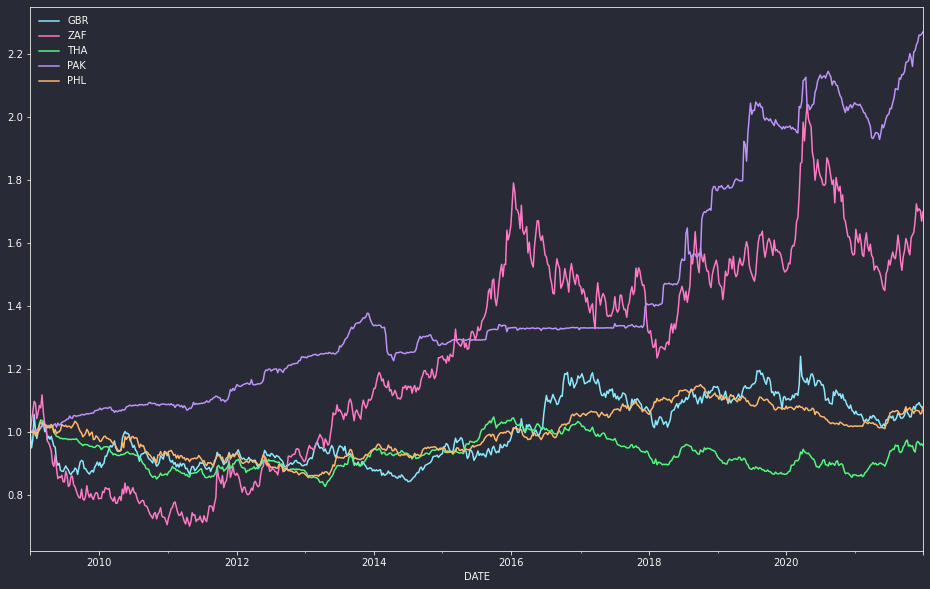

In [9]:
to_plot = fx#.iloc[:,0:]
to_plot /= to_plot.iloc[0,:]
to_plot.plot()
plt.legend(COUNTRIES[1:])
plt.show()

In [10]:
class FXCarry:
    
    def __init__(self, cou: pd.DataFrame, zeros: pd.DataFrame, 
                 fx: pd.DataFrame, lend: list):
        """Evaluates the profitability of holding a foreign bond with
        adjustments to FX rates and leverage.
        lend: list contains the names of the countries in which the strategy lends
        """
        self.strat = pd.concat([cou.shift(1), zeros], axis=1, keys=["COU", "ZER"])
        self.strat.columns.names = ["TYPE", "COUNTRY", "TENOR"]
        self.premium = 0.005 # 50bp
        self.funding = (cou[("GBR", 0.08)] + self.premium) /52 # weekly funding
        self.fx = fx
        self.lend = lend
        self.equity = 2e6
        self.leverage = 5
        self.notional = self.equity * self.leverage
        self.long_tenor = 5 # Sell 5 year bonds
        self.fx_ret = self.fx_return(self.fx, self.leverage)
        self.bond_ret = self.run_strategy(self.strat)
        self.interest = self.accrue_interest(self.leverage, self.funding)
        self.adj_ret = self.fx_fund_adj(self.bond_ret, self.fx_ret[self.lend], 
                                        self.interest)
        self.lev_ret = self.leverage_adj(self.adj_ret, self.leverage)
    
    def accrue_interest(self, lev, fund):
        """OIS + premium"""
        pct_lev = (lev - 1) / lev
        return fund * pct_lev
        
    def run_strategy(self, strat):
        """Iterates through trading dates and foreign bonds"""
        exits = {l: [] for l in self.lend}
        for d, row in strat.iterrows():
            countries = row.index.get_level_values(1)
            for l in self.lend:
                # row contains all countries. Filter for each lending country
                r = row[countries==l]
                if r.isna().any(): exits[l].append(np.nan)
                else: exits[l].append(self.value_off_run(r))
        return pd.DataFrame(exits, index=self.strat.index)
    
    def value_off_run(self, row):
        """Computes the value of off-the-run bonds. Uses Zero rates
        to determine the present value of each cashflow"""
        df = row.rename("RATE").reset_index()
        zeros = df.loc[df["TYPE"]=="ZER", ["TENOR", "RATE"]]
        rate = df.loc[(df["TYPE"]=="COU") & (df["TENOR"]==self.long_tenor), "RATE"].values[0]
        coupon = rate / 4 # quarterly payments
        times = np.arange(self.long_tenor-1/52, 0, step=-0.25)[::-1]
        zero_interp = np.interp(times, zeros["TENOR"], zeros["RATE"])
        value = (coupon * np.exp(-zero_interp * times)).sum() + np.exp(-zero_interp[-1] * times[-1])
        return value
    
    def fx_return(self, fx, leverage):
        """Computes FX return using level and adjusts charges based on leverage"""
        return (fx.shift(1).bfill() / fx - 1) / leverage + 1
    
    def fx_fund_adj(self, bond_ret, fx_ret, interest):
        """As USD Investors, adjust returns based on FX rate changes and funding interest"""
        return (bond_ret * fx_ret.values).subtract(interest, axis=0)
    
    def leverage_adj(self, ret, leverage):
        return (ret - 1) * leverage + 1



lend = COUNTRIES[2:]

carry = FXCarry(cou, zeros, fx, lend)

<AxesSubplot:xlabel='Date'>

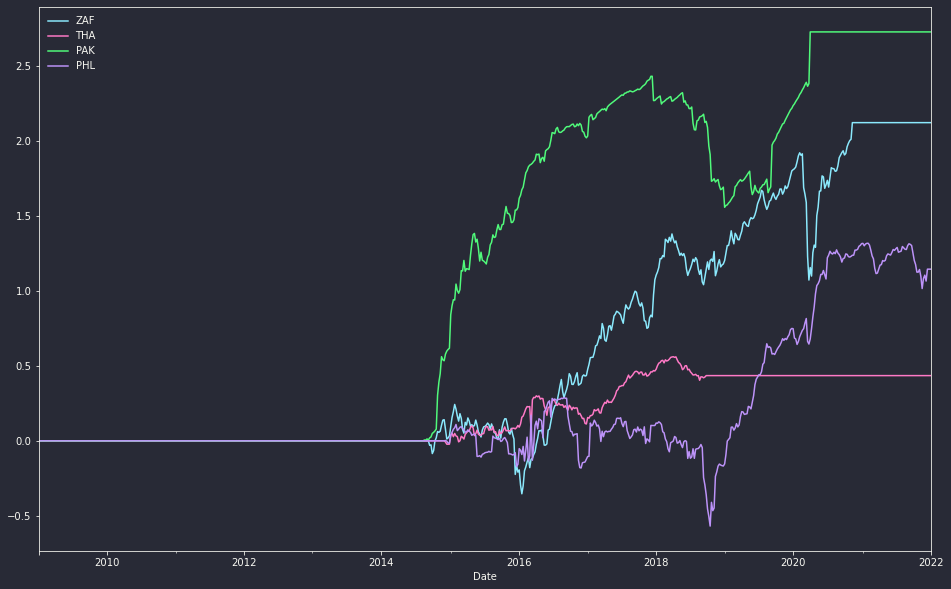

In [11]:
(carry.lev_ret.fillna(1)-1).cumsum().plot()

<AxesSubplot:xlabel='Date'>

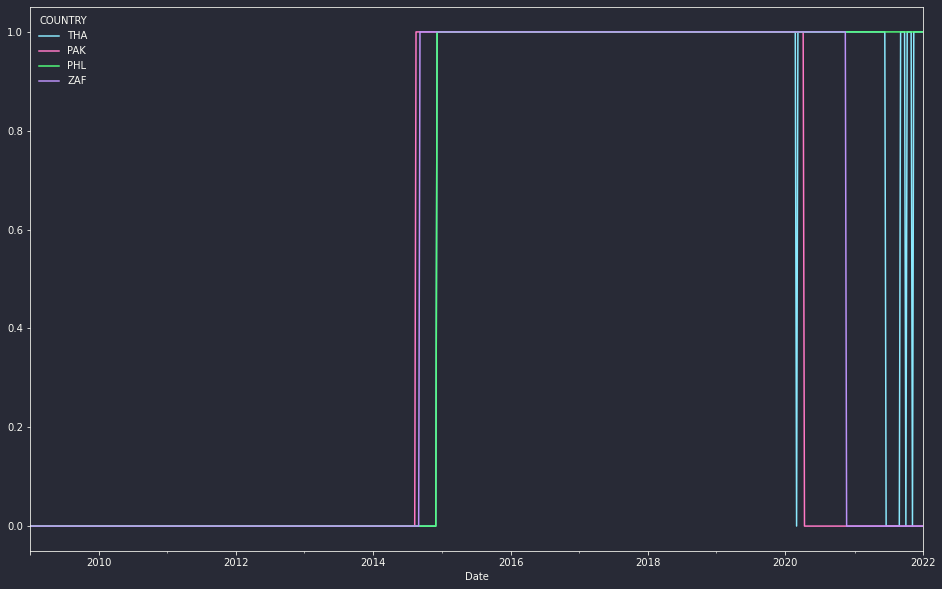

In [12]:
mask = (carry.strat.columns.get_level_values(0)=="COU") 
mask &=(carry.strat.columns.get_level_values(2)==5)

temp = carry.strat.loc[:,mask]
temp.columns = temp.columns.droplevel(["TYPE", "TENOR"])
temp.iloc[:, 1:].gt(temp["GBR"]+0.005, axis=0).astype(int).plot()